## MountainCar-v0 Question: 

### Observation

观测值，即智能体的状态，包括位置和速度，具体取值范围如下：  
位置：-1.2 —— 0.6  
速度：-0.07 —— 0.07

### Actions

智能体的行为，一种只有三种：  
0（向左）  
1（不动）  
2（向右）

### Reward

每一步的回报为-1，到达目标山峰的回报为0.5。
到达左边山顶没有定义，相当于触碰了墙壁。

### Starting State

位置为(-0.6，-0.4)之间的随机位置，速度为0。

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model

In [10]:
#导入模型，MountainCar问题
env = gym.make("MountainCar-v0")
env.reset()

array([-0.51611313,  0.        ])

# Parameter

In [11]:
#基本参数
alpha = 0.5 #学习率
gama = 0.95 #折现因子
episodes_num = 2000 #训练轮数
display_num = 200 #训练时每隔多少轮显示进度
Qtable_size = 20 #Q表的长度

#离散化参数
discrete_size = [Qtable_size] * len(env.observation_space.high) #20*20
discrete_step = (env.observation_space.high - env.observation_space.low) / discrete_size #单位步长
q_table = np.zeros(discrete_size + [env.action_space.n]) #Q表初始化，大小：20*20*3

#ε参数
#初始为１，后续随训练轮数逐渐减小
epsilon = 1
start_episode = 1
end_episode = episodes_num//2
#每步递减值
de_step = epsilon/(end_episode - start_episode)

# Auxiliary Function

In [12]:
#辅助函数
#离散化状态——将连续的状态变位离散的状态
def get_discrete_state (state):
    discrete_state = (state - env.observation_space.low) // discrete_step
    return tuple(discrete_state.astype(int))

#ε—贪心策略执行行动
def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.argmax(q_table[discrete_state])
    return action

#  Storage

In [13]:
#回报存储
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

# Train

In [14]:
#训练
for episode in range(episodes_num):
    # initiate reward every episode
    ep_reward = 0
    if episode % display_num == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    done = False
    while not done:
        #行为策略：St——At
        action = take_epilon_greedy_action(state, epsilon) 
        #St，At——Rt+1，St+1
        next_state, reward, done, _ = env.step(action)
        #回报累计
        ep_reward += reward

        # if render:
        #     env.render()
        
        #未结束
        if not done: 
            #贪心策略决定At+1
            td_target = reward + gama * np.max(q_table[get_discrete_state(next_state)]) 
            #更新Q(St，At)
            q_table[get_discrete_state(state)][action] += alpha * (td_target - q_table[get_discrete_state(state)][action])

        #到达目标点，结束
        elif next_state[0] >= 0.5: 
            # print("I made it on episode: {} Reward: {}".format(episode,reward))
            q_table[get_discrete_state(state)][action] = 0

        #状态迭代
        state = next_state

    # ε值的递减
    if end_episode >= episode >= start_episode:
        epsilon -= de_step

    # 每轮回报值的存储
    ep_rewards.append(ep_reward)

    # 每个SHOW_EVERY轮显示并存储数据
    if episode % display_num == 0:
        avg_reward = sum(ep_rewards[-display_num:]) / len(ep_rewards[-display_num:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-display_num:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-display_num:]))

episode: 0
episode: 200
episode: 400
episode: 600
episode: 800
episode: 1000
episode: 1200
episode: 1400
episode: 1600
episode: 1800


# Display Rewards

Text(0, 0.5, 'Rewards')

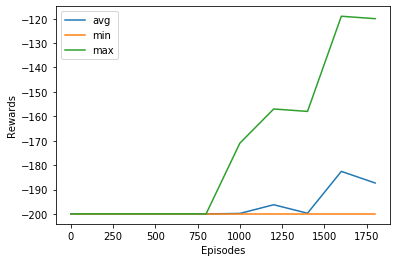

In [15]:
#回报展示
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

# Test

In [20]:
#训练结果测试
done = False
state = env.reset()
while not done:
    action = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()
env.close()